In [2]:
%matplotlib widget
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import morph_geom_lib as mgl
import models.shallow_depth_morph_models as sdmodels
import schemes.avalanche_scheme 


from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')

%load_ext autoreload
%autoreload 2
%matplotlib inline

dx: 0.9762202753441801 cm
nx 800


Text(0, 0.5, 'z (m)')

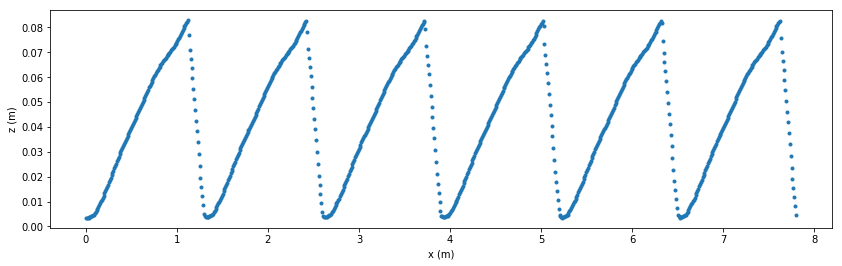

In [3]:
filepath = '../Paper_3/dune_profile_dune5_repeated.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 800)

dx = x0[1] - x0[0]

'''z0slope = z0.copy()
dx = x0[1] - x0[0]
for i in range(len(z0)):
    z0[i] = z0[i] - dx*( 1.26/1000. )'''




print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [4]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.002

#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 300*60       # Runtime in seconds
dt = 5                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*5

qin  0.0868421052631579
num_dim: 1
2019-05-21 15:42:53,478 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-21 15:42:54,298 INFO CLAW: Solution 1 computed for time t=10.000000
2019-05-21 15:42:55,093 INFO CLAW: Solution 2 computed for time t=20.000000
2019-05-21 15:42:55,924 INFO CLAW: Solution 3 computed for time t=30.000000
2019-05-21 15:42:56,610 INFO CLAW: Solution 4 computed for time t=40.000000
2019-05-21 15:42:57,312 INFO CLAW: Solution 5 computed for time t=50.000000
2019-05-21 15:42:58,092 INFO CLAW: Solution 6 computed for time t=60.000000
2019-05-21 15:42:58,912 INFO CLAW: Solution 7 computed for time t=70.000000
2019-05-21 15:42:59,618 INFO CLAW: Solution 8 computed for time t=80.000000
2019-05-21 15:43:00,354 INFO CLAW: Solution 9 computed for time t=90.000000
2019-05-21 15:43:01,136 INFO CLAW: Solution 10 computed for time t=100.000000
0.2369976004514732
0.4721950881656135
0.18869886036623235


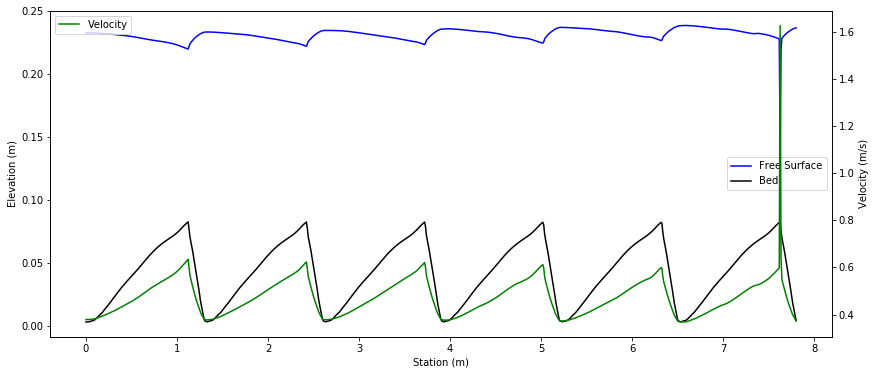

In [6]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)
#model.set_mannings_source_term(mannings=0.022, slope=1/792.)

model.set_Dirichlet_BC(sOut20, q20cm*1.1)
model.set_inital_conditions(sOut32, 0.0)
model.set_controller(tfinal = 100, num_output_times=10)
model.run()

h = model.get_hf()
surf = h + z0
u = model.get_uf()

fig,ax1 = plt.subplots(figsize=(14, 6))
plt.plot(x0, surf, color='b', label='Free Surface')
plt.plot(x0, z0, color='k', label = 'Bed')
plt.ylabel('Elevation (m)')
plt.legend()
plt.xlabel('Station (m)')
ax2 = ax1.twinx() 
ax2.plot(x0, u, color='g', label='Velocity')
ax2.set_ylabel('Velocity (m/s)')

plt.legend()

print(surf[len(x0)-1])
print(model.get_uf().mean())
print(h.mean())


dx: 0.704469646430954 cm
nx 1500


Text(0, 0.5, 'z (m)')

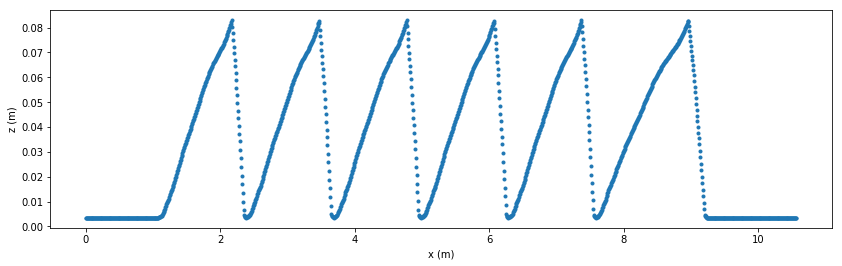

In [79]:
filepath = '../Paper_3/dune_profile_dune5_rep_runway.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 1500)

dx = x0[1] - x0[0]

'''z0slope = z0.copy()
dx = x0[1] - x0[0]
for i in range(len(z0)):
    z0[i] = z0[i] - dx*( 1.26/1000. )'''




print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

qin  0.07894736842105263
num_dim: 1
2019-05-21 04:01:54,936 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-21 04:02:00,046 INFO CLAW: Solution 1 computed for time t=30.000000
2019-05-21 04:02:03,962 INFO CLAW: Solution 2 computed for time t=60.000000
2019-05-21 04:02:07,821 INFO CLAW: Solution 3 computed for time t=90.000000
2019-05-21 04:02:11,356 INFO CLAW: Solution 4 computed for time t=120.000000
2019-05-21 04:02:15,095 INFO CLAW: Solution 5 computed for time t=150.000000
2019-05-21 04:02:18,805 INFO CLAW: Solution 6 computed for time t=180.000000
2019-05-21 04:02:22,549 INFO CLAW: Solution 7 computed for time t=210.000000
2019-05-21 04:02:26,559 INFO CLAW: Solution 8 computed for time t=240.000000
2019-05-21 04:02:30,007 INFO CLAW: Solution 9 computed for time t=270.000000
2019-05-21 04:02:33,386 INFO CLAW: Solution 10 computed for time t=300.000000
0.23699346190208603
0.41601850531855067
0.1947648210943583


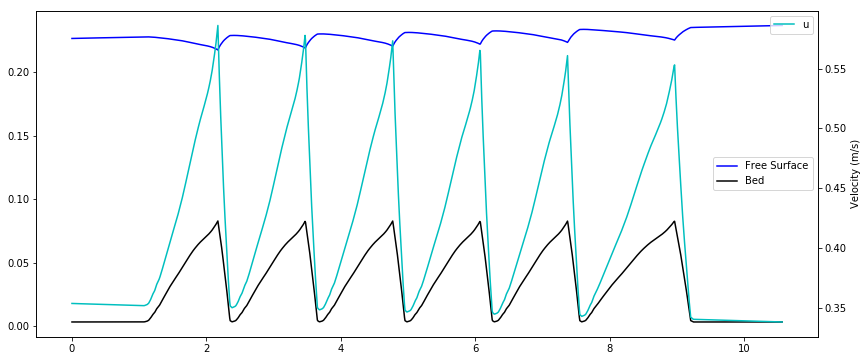

In [81]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)
#model.set_mannings_source_term(mannings=0.022, slope=1/792.)

model.set_Dirichlet_BC(sOut20, q20cm)
model.set_inital_conditions(sOut32, 0.0)
model.set_controller(tfinal = 300, num_output_times=10)
model.run()

h = model.get_hf()
surf = h + z0
u = model.get_uf()

fig,ax1 = plt.subplots(figsize=(14, 6))
plt.plot(x0, surf, color='b', label='Free Surface')
plt.plot(x0, z0, color='k', label = 'Bed')
plt.legend()
ax2 = ax1.twinx() 
ax2.plot(x0, u, color='c', label='u')
ax2.set_ylabel('Velocity (m/s)')

plt.legend()

print(surf[len(x0)-1])
print(model.get_uf().mean())
print(h.mean())